In [1]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# 设置环境
env = gym.make('MountainCar-v0')
env = env.unwrapped # 解除环境200步的限制
env.seed(0) # 设置随机种子

# 参数设置
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
learning_rate = 1e-2
gamma = 0.99

# 定义策略网络
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 64),  # 隐藏层 64 单元
            nn.ReLU(),
            nn.Linear(64, action_dim),  # 输出层：动作的 logits
            nn.Softmax(dim=-1)  # 通过 Softmax 输出动作的概率
        )
        # 初始化权重，两个全连接层的权重矩阵初始值服从均值为0、标准差为0.01的正态分布，偏置量初始值为0.1
        nn.init.normal_(self.fc[0].weight, mean=0, std=0.01)
        nn.init.constant_(self.fc[0].bias, 0.1)
        nn.init.normal_(self.fc[2].weight, mean=0, std=0.01)
        nn.init.constant_(self.fc[2].bias, 0.1)
        
    def forward(self, state):
        return self.fc(state)

# 值函数网络
class ValueNetwork(nn.Module):
    def __init__(self, state_dim):
        super(ValueNetwork, self).__init__()
        self.fc = nn.Linear(state_dim, 64)
        self.out = nn.Linear(64, 1)

        # 初始化权重和偏置
        nn.init.normal_(self.fc.weight, mean=0.0, std=0.01)
        nn.init.constant_(self.fc.bias, 0.1)
        nn.init.normal_(self.out.weight, mean=0.0, std=0.01)
        nn.init.constant_(self.out.bias, 0.1)

    def forward(self, x):
        x = torch.relu(self.fc(x))
        return self.out(x)
    
    # 计算折扣累积奖励
def compute_returns(rewards, gamma=0.99):
    returns = []
    R = 0
    for r in reversed(rewards):  # 反向遍历奖励，计算回报
        R = r + gamma * R
        returns.insert(0, R)  # 插入回报
    return returns

def compute_returns_standard(rewards, gamma=0.99):
    '''
    计算折扣累积奖励，并标准化
    '''
    returns = []
    R = 0
    for r in reversed(rewards):  # 反向遍历奖励，计算回报
        R = r + gamma * R
        returns.insert(0, R)  # 插入回报
    returns = np.array(returns)
    # 标准化
    returns = (returns - returns.mean()) / (returns.std() + 1e-8)
    return returns

Episode 0, Total Reward: -28865.00, learning rate: 0.010000
Episode 10, Total Reward: -1429.00, learning rate: 0.010000
Episode 20, Total Reward: -3390.00, learning rate: 0.010000
Episode 30, Total Reward: -2750.00, learning rate: 0.010000
Episode 40, Total Reward: -1154.00, learning rate: 0.010000
Episode 50, Total Reward: -1893.00, learning rate: 0.010000
Episode 60, Total Reward: -2024.00, learning rate: 0.010000
Episode 70, Total Reward: -1341.00, learning rate: 0.010000
Episode 80, Total Reward: -1857.00, learning rate: 0.010000
Episode 90, Total Reward: -1826.00, learning rate: 0.010000
Episode 100, Total Reward: -671.00, learning rate: 0.010000
Episode 110, Total Reward: -1322.00, learning rate: 0.010000
Episode 120, Total Reward: -1322.00, learning rate: 0.010000
Episode 130, Total Reward: -3257.00, learning rate: 0.010000
Episode 140, Total Reward: -4404.00, learning rate: 0.010000
Episode 150, Total Reward: -1420.00, learning rate: 0.010000
Episode 160, Total Reward: -820.00,

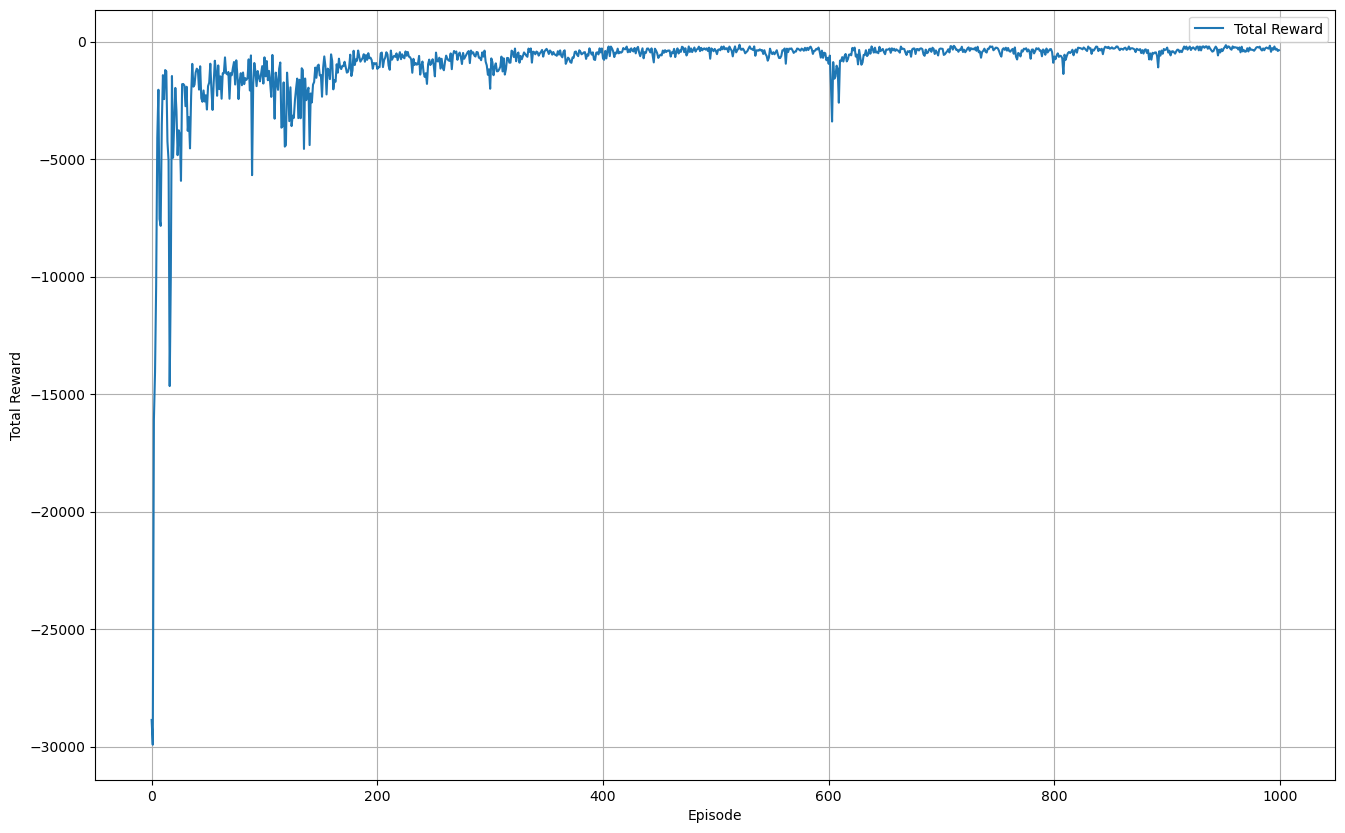

In [2]:
# 初始化策略网络和优化器
policy = PolicyNetwork(state_dim, action_dim)
optimizer = optim.Adam(policy.parameters(), lr=learning_rate)
total_rewards = []
total_steps = []
max_total_reward = -np.inf

%matplotlib qt
plt.ion()
fig, ax = plt.subplots(1, 1, figsize=(16, 10))
ax.set_xlabel('Episode')
ax.set_ylabel('Total Reward')
line, = ax.plot([], [], label='Total Reward')
ax.legend()
# 添加网格线
ax.grid(True)

# 训练 REINFORCE
num_episodes = 1000
for episode in range(num_episodes):
    state = env.reset()
    log_probs = []
    rewards = []
    done = False
    step_count = 0
    while not done:
        state_tensor = torch.FloatTensor(state)
        action_probs = policy(state_tensor)
        action_dist = torch.distributions.Categorical(action_probs)
        action_tensor = action_dist.sample()
        # 随机策略选择动作
        action = action_tensor.item()
        
        log_probs.append(action_dist.log_prob(action_tensor))  # 记录 log 概率
        
        next_state, reward, done, _ = env.step(action)  # 执行动作
        step_count += 1
        # 如果到达目标位置
        #if next_state[0] >= env.unwrapped.goal_position:
        
        rewards.append(reward)  # 记录奖励
        
        state = next_state
        if step_count > 50000:
            break
    total_steps.append(step_count)
    # 计算折扣累积奖励
    returns = compute_returns_standard(rewards, gamma)
    returns = torch.FloatTensor(returns)
    
    # 计算损失
    loss = 0
    for log_prob, R in zip(log_probs, returns):
        loss -= log_prob * R  # 策略梯度的损失函数
    
    current_total_reward = sum(rewards)
    # 更新策略网络
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_rewards.append(current_total_reward)
    # 绘制奖励曲线
    line.set_data(range(len(total_rewards)), total_rewards)
    ax.relim()
    ax.autoscale_view()
    plt.pause(0.05)

    # 保存奖励最高的模型
    if max_total_reward < current_total_reward:
        max_total_reward = current_total_reward
        # 保存模型：游戏名+算法名+网络类型
        torch.save(policy.state_dict(), env.spec.id + '_REINFORCE_PolicyNetwork_best.pth')

    # 回合数为500的倍数的时候，降低学习率
    '''if current_total_reward > -200:
        # 降低学习率
        #print("Learning rate reduced by 10")
        for param_group in optimizer.param_groups:
            param_group['lr'] = max(param_group['lr'] * 0.5, learning_rate * 1e-3)
    elif current_total_reward < -10000:
        # 提高学习率
        #print("Learning rate increased by 10")
        for param_group in optimizer.param_groups:
            param_group['lr'] = min(param_group['lr'] * 2, learning_rate)'''

    # 输出训练信息
    if episode % 10 == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Episode {episode}, Total Reward: {sum(rewards):.2f}, learning rate: {current_lr:.6f}")
    plt.ioff()
    plt.show
print(f"Episode {episode}, Total Reward: {sum(rewards):.2f}")
print("Training Complete")
env.close()
# 保存模型：游戏名+算法名+网络类型
torch.save(policy.state_dict(), env.spec.id + '_REINFORCE_PolicyNetwork.pth')
# 重新设置为行内显示
%matplotlib inline
'''plt.plot(total_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
# 重置XY轴
plt.xlim(-10, len(total_rewards) + 10)
plt.ylim(min(total_rewards) - 10, max(total_rewards) + 10000)'''
plt.show()

Episode 0, Total Reward: -33789.00
Episode 10, Total Reward: -706.00
Episode 20, Total Reward: -3119.00
Episode 30, Total Reward: -1150.00
Episode 40, Total Reward: -2633.00
Episode 50, Total Reward: -2467.00
Episode 60, Total Reward: -1190.00
Episode 70, Total Reward: -1977.00
Episode 80, Total Reward: -1483.00
Episode 90, Total Reward: -1523.00
Episode 100, Total Reward: -6340.00
Episode 110, Total Reward: -1137.00
Episode 120, Total Reward: -4420.00
Episode 130, Total Reward: -3364.00
Episode 140, Total Reward: -1913.00
Episode 150, Total Reward: -2435.00
Episode 160, Total Reward: -1884.00
Episode 170, Total Reward: -5529.00
Episode 180, Total Reward: -9535.00
Episode 190, Total Reward: -5176.00
Episode 200, Total Reward: -4681.00
Episode 210, Total Reward: -1043.00
Episode 220, Total Reward: -710.00
Episode 230, Total Reward: -2034.00
Episode 240, Total Reward: -2970.00
Episode 250, Total Reward: -4015.00
Episode 260, Total Reward: -3863.00
Episode 270, Total Reward: -2787.00
Epis

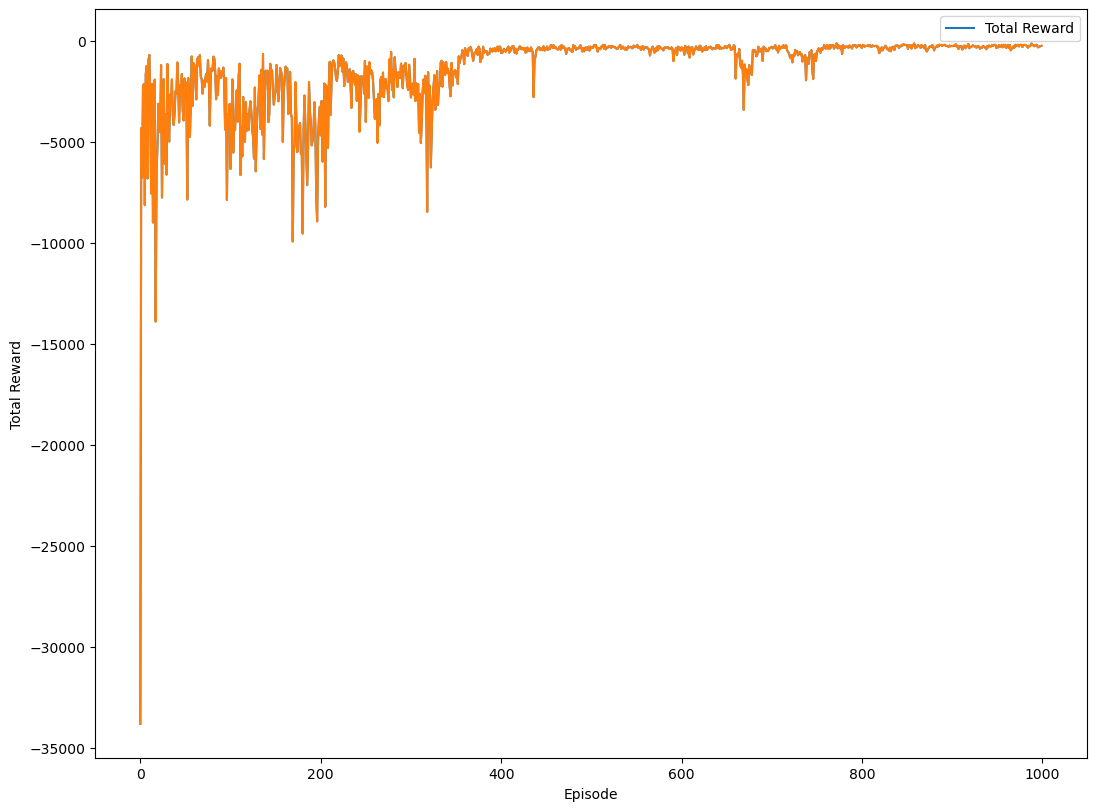

In [3]:
policy_net = PolicyNetwork(state_dim, action_dim)
value_net = ValueNetwork(state_dim)

policy_optimizer = optim.Adam(policy_net.parameters(), lr=1e-2)
value_optimizer = optim.Adam(value_net.parameters(), lr=1e-2)
total_rewards = []
%matplotlib qt
plt.ion()
fig, ax = plt.subplots()
ax.set_xlabel('Episode')
ax.set_ylabel('Total Reward')
line, = ax.plot([], [], label='Total Reward')
ax.legend()

# 训练循环
num_episodes = 1000
for episode in range(num_episodes):
    state = env.reset()
    log_probs = []
    rewards = []
    values = []
    done = False
    step_count = 0
    while not done:
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        
        # 策略选择动作
        action_probs = policy_net(state_tensor)
        action_dist = torch.distributions.Categorical(action_probs)
        action = action_dist.sample()
        
        log_probs.append(action_dist.log_prob(action))
        
        # 记录值函数预测
        values.append(value_net(state_tensor))
        
        # 交互
        next_state, reward, done, _ = env.step(action.item())
        step_count += 1
        rewards.append(reward)
        state = next_state

    # 计算折扣累积奖励
    returns = compute_returns(rewards, gamma)
    returns = torch.FloatTensor(returns)
    # 计算 Advantage
    values = torch.cat(values).squeeze()
    advantages = returns - values.detach()
    # 标准化 Advantages
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    # 更新策略网络
    policy_loss = -torch.sum(torch.stack(log_probs).squeeze(1) * advantages)
    policy_optimizer.zero_grad()
    policy_loss.backward()
    policy_optimizer.step()

    # 更新值函数网络
    value_loss = torch.nn.functional.mse_loss(values, returns)
    value_optimizer.zero_grad()
    value_loss.backward()
    value_optimizer.step()

    total_rewards.append(sum(rewards))
    line.set_data(range(len(total_rewards)), total_rewards)
    ax.relim()
    ax.autoscale_view()
    plt.pause(0.05)

    # 日志输出
    if episode % 10 == 0:
        print(f"Episode {episode}, Total Reward: {sum(rewards):.2f}")

print(f"Episode {episode}, Total Reward: {sum(rewards):.2f}")
print("Training Complete")
env.close()
# 保存模型：游戏名+算法名+网络类型
torch.save(policy_net.state_dict(), env.spec.id + '_REINFORCE_Baseline_PolicyNetwork.pth')
torch.save(value_net.state_dict(), env.spec.id + '_REINFORCE_Baseline_ValueNetwork.pth')
# 重新设置为行内显示
%matplotlib inline
plt.plot(total_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

In [ ]:
import gym
import time

# 初始化环境
env = gym.make('MountainCar-v0')
env = env.unwrapped
# 打印环境信息
print('观测空间 = {}'.format(env.observation_space))
print('动作空间 = {}'.format(env.action_space))
print('位置范围 = {}'.format((env.unwrapped.min_position,
        env.unwrapped.max_position)))
print('速度范围 = {}'.format((-env.unwrapped.max_speed,
        env.unwrapped.max_speed)))
print('目标位置 = {}'.format(env.unwrapped.goal_position))

policy_net = PolicyNetwork(state_dim, action_dim)
# 加载模型参数
REINFORCE_Baseline_PolicyNetwork = env.spec.id + '_REINFORCE_Baseline_PolicyNetwork.pth' # 带基线的REINFORCE策略网络
REINFORCE_PolicyNetwork = env.spec.id + '_REINFORCE_PolicyNetwork.pth' # REINFORCE策略网络
policy_net.load_state_dict(torch.load(REINFORCE_PolicyNetwork, weights_only=True))
policy_net.eval()
# 重置环境
state = env.reset()

select_action_policy = 0 # 0: 贪心策略，1: 随机策略

# 运行一个随机策略
done = False
step_count = 0
while not done:
    env.render()  # 可视化环境
    time.sleep(1 / 30)  # 控制帧率
    #action = env.action_space.sample()  # 随机选择一个动作
    state_tensor = torch.FloatTensor(state)
    action_probs = policy_net(state_tensor)
    if select_action_policy == 0:
        # 贪心策略选择动作        
        action = torch.argmax(action_probs).item()
        next_state, reward, done, info = env.step(action)  # 执行动作并获取新状态和奖励
    else:
        # 随机策略选择动作
        action_dist = torch.distributions.Categorical(action_probs)
        action = action_dist.sample().item()
        next_state, reward, done, info = env.step(action)  # 执行动作并获取新状态和奖励

    #print(f"step_count: {step_count}, info: {info}")
    state = next_state
    step_count += 1
    # 如果到达目标位置
    if next_state[0] >= env.unwrapped.goal_position:
        done = True
    if step_count >= 200:
        break
print(f"Episode finished after {step_count} steps")
env.close()


观测空间 = Box(-1.2000000476837158, 0.6000000238418579, (2,), float32)
动作空间 = Discrete(3)
位置范围 = (-1.2, 0.6)
速度范围 = (-0.07, 0.07)
目标位置 = 0.5
Episode finished after 179 steps
